# Module 2: Multimodal Fusion + RAG-based Behavioral Coaching

## Objective
This module integrates multiple data sources to build a personalized behavioral coaching system for users:

1. **Multimodal Fusion**: Combine features from NLP (Module 1) and Computer Vision.
2. **Risk Assessment**: Estimate an overall aggregated risk level.
3. **RAG-based Coaching**: Retrieve guidance from AAO (American Academy of Ophthalmology) materials.
4. **Behavioral Recommendations**: Generate personalized behavioral recommendations.
5. **Safety Filter**: Ensure the system does not provide medical advice.

## System Architecture
```
NLP Features (Module 1) ──┐
                          ├──> Multimodal Fusion ──> Risk Assessment
CV Features (Camera)   ───┘                                │
                                                           │
AAO Guidelines Database ──> RAG Retriever ────────────────┤
                                                           │
                                                           ▼
                                              Explanation Generator
                                                           │
                                                           ▼
                                          Behavioral Recommendations
                                                           │
                                                           ▼
                                                    Safety Filter
                                                           │
                                                           ▼
                                                    Final Output
```

## 1. Import Libraries

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Data Classes

In [3]:
@dataclass
class CVFeatures:
    """Computer Vision features from monitoring system"""
    risk_level: float  # 0.0-1.0
    posture_score: float  # 0-100
    blink_rate: int  # blinks per minute
    screen_distance: float  # cm
    duration_minutes: int  # session duration


@dataclass
class NLPFeatures:
    """NLP features from Module 1"""
    discomfort_level: int  # 1-4
    severity_label: str  # None/Nhẹ/Vừa/Nặng
    confidence: float
    extracted_symptoms: List[str]
    original_text: str


print("✅ Data classes defined!")
print("\n📋 Available features:")
print("  - CVFeatures: risk_level, posture_score, blink_rate, screen_distance, duration_minutes")
print("  - NLPFeatures: discomfort_level, severity_label, confidence, extracted_symptoms, original_text")

✅ Data classes defined!

📋 Available features:
  - CVFeatures: risk_level, posture_score, blink_rate, screen_distance, duration_minutes
  - NLPFeatures: discomfort_level, severity_label, confidence, extracted_symptoms, original_text


## 3. Multimodal Fusion

Combine data from NLP and Computer Vision to produce an aggregated risk assessment.

In [4]:
class MultimodalFusion:
    """Fuse NLP and CV features into unified risk assessment"""
    
    def __init__(self):
        # Weights for different features (can be tuned)
        self.weights = {
            'nlp_severity': 0.4,      # 40% - User-reported symptoms
            'cv_risk': 0.3,           # 30% - Overall CV risk
            'posture': 0.15,          # 15% - Posture quality
            'blink_rate': 0.10,       # 10% - Blink frequency
            'screen_distance': 0.05   # 5% - Screen distance
        }
    
    def calculate_risk_score(
        self,
        nlp_features: NLPFeatures,
        cv_features: CVFeatures
    ) -> Dict:
        """
        Calculate combined risk score from multiple modalities
        
        Returns:
            Dictionary with comprehensive risk assessment
        """
        # Normalize NLP severity (1-4 → 0-1)
        nlp_risk = (nlp_features.discomfort_level - 1) / 3.0
        
        # Normalize posture (0-100 → 1-0, lower score = higher risk)
        posture_risk = 1.0 - (cv_features.posture_score / 100.0)
        
        # Normalize blink rate (healthy: 15-20/min, lower = worse)
        blink_risk = max(0, 1.0 - (cv_features.blink_rate / 15.0))
        
        # Normalize distance (optimal: 50-70cm)
        if cv_features.screen_distance < 40:
            distance_risk = 1.0 - (cv_features.screen_distance / 40.0)
        elif cv_features.screen_distance > 80:
            distance_risk = (cv_features.screen_distance - 80) / 40.0
        else:
            distance_risk = 0.0
        distance_risk = min(1.0, distance_risk)
        
        # Weighted combination
        combined_risk = (
            self.weights['nlp_severity'] * nlp_risk +
            self.weights['cv_risk'] * cv_features.risk_level +
            self.weights['posture'] * posture_risk +
            self.weights['blink_rate'] * blink_risk +
            self.weights['screen_distance'] * distance_risk
        )
        
        # Classify risk level
        if combined_risk < 0.3:
            risk_category = "LOW"
            urgency = "normal"
        elif combined_risk < 0.6:
            risk_category = "MEDIUM"
            urgency = "caution"
        else:
            risk_category = "HIGH"
            urgency = "immediate"
        
        return {
            'combined_risk_score': combined_risk,
            'risk_category': risk_category,
            'urgency': urgency,
            'component_risks': {
                'nlp_severity': nlp_risk,
                'cv_overall': cv_features.risk_level,
                'posture': posture_risk,
                'blink_rate': blink_risk,
                'screen_distance': distance_risk
            }
        }


print("✅ MultimodalFusion class created!")

✅ MultimodalFusion class created!


## 4. AAO Guidelines Database (RAG)

Guideline knowledge base from the American Academy of Ophthalmology (AAO).
In production, a vector database such as ChromaDB or FAISS will be used.

In [5]:
class AAOGuidelineRetriever:

    
    def __init__(self):
        # AAO guidelines database (simplified version)
        self.guidelines = {
            'blink_rate': {
                'title': 'Blink Rate and Dry Eyes',
                'content': '''
                Normal blink rate is 15-20 times per minute. When using screens,
                blink rate can drop to 5-7 times per minute, leading to dry eye symptoms.
                
                Recommendations:
                - Practice conscious blinking
                - Follow 20-20-20 rule
                - Use artificial tears if needed
                ''',
                'source': 'AAO Dry Eye Guidelines 2023'
            },
            'screen_distance': {
                'title': 'Optimal Screen Distance',
                'content': '''
                Recommended screen distance is 50-70cm (arm's length) from eyes.
                Screens should be positioned 15-20 degrees below eye level.
                
                Too close (<40cm): Causes eye strain and accommodation stress
                Too far (>80cm): May cause squinting and posture issues
                
                Recommendations:
                - Position monitor at arm's length
                - Adjust chair height and monitor position
                - Use larger fonts if needed instead of moving closer
                ''',
                'source': 'AAO Computer Vision Syndrome Guidelines'
            },
            'posture': {
                'title': 'Ergonomic Posture for Eye Health',
                'content': '''
                Poor posture affects eye strain indirectly through:
                - Neck and shoulder tension affecting blood flow
                - Suboptimal viewing angles causing accommodation stress
                - Increased screen glare from wrong angles
                
                Recommendations:
                - Sit with back supported
                - Feet flat on floor
                - Monitor top at or slightly below eye level
                - Avoid hunching forward
                ''',
                'source': 'AAO Occupational Health Guidelines'
            },
            '20-20-20_rule': {
                'title': 'The 20-20-20 Rule',
                'content': '''
                Every 20 minutes, look at something 20 feet (6 meters) away
                for at least 20 seconds. This helps:
                - Relax accommodation muscles
                - Stimulate blinking
                - Reduce eye strain
                
                Additional recommendations:
                - Take longer breaks (5-10 min) every hour
                - Look out a window if possible
                - Close eyes briefly during breaks
                ''',
                'source': 'AAO Digital Eye Strain Prevention'
            },
            'exercise': {
                'title': 'Eye Relaxation Exercises',
                'content': '''
                Recommended exercises for eye strain relief:
                
                1. Palming: Rub hands together, cup over closed eyes for 30 seconds
                2. Eye rolling: Slowly roll eyes clockwise, then counterclockwise
                3. Focus shifting: Alternate focus between near and far objects
                4. Blinking exercises: Blink rapidly 10 times, then close eyes
                
                Frequency: Every 30-60 minutes during screen work
                ''',
                'source': 'AAO Eye Exercise Guidelines'
            }
        }
    
    def retrieve_relevant_guidelines(
        self,
        risk_assessment: Dict,
        nlp_features: NLPFeatures,
        cv_features: CVFeatures
    ) -> List[Dict]:

        relevant = []
        
        # Check blink rate
        if cv_features.blink_rate < 12:
            relevant.append(self.guidelines['blink_rate'])
        
        # Check screen distance
        if cv_features.screen_distance < 40 or cv_features.screen_distance > 80:
            relevant.append(self.guidelines['screen_distance'])
        
        # Check posture
        if cv_features.posture_score < 60:
            relevant.append(self.guidelines['posture'])
        
        # Always recommend 20-20-20 for any risk
        if risk_assessment['risk_category'] in ['MEDIUM', 'HIGH']:
            relevant.append(self.guidelines['20-20-20_rule'])
        
        # Add exercises for moderate/severe symptoms
        if nlp_features.discomfort_level >= 3:
            relevant.append(self.guidelines['exercise'])
        
        return relevant


print(" AAOGuidelineRetriever created!")
print(f"\n Available guidelines: {len(AAOGuidelineRetriever().guidelines)}")
print("  - blink_rate")
print("  - screen_distance")
print("  - posture")
print("  - 20-20-20_rule")
print("  - exercise")

 AAOGuidelineRetriever created!

 Available guidelines: 5
  - blink_rate
  - screen_distance
  - posture
  - 20-20-20_rule
  - exercise


## 5. Explanation Generator

Generate clear and understandable explanations of the causes and consequences of user behaviors.

In [6]:
class ExplanationGenerator:
    """Generate human-readable explanations for risk factors"""
    
    def generate_behavior_consequence_map(
        self,
        risk_assessment: Dict,
        cv_features: CVFeatures
    ) -> Dict:
        consequences = {}
        
        # Blink rate
        if cv_features.blink_rate < 12:
            consequences['low_blink_rate'] = {
                'behavior': f'Blinking only {cv_features.blink_rate} times per minute (low)',
                'consequence': 'Dry eyes, itching sensation, and redness due to tear film evaporation',
                'severity': 'HIGH' if cv_features.blink_rate < 8 else 'MEDIUM'
            }

        # Screen distance
        if cv_features.screen_distance < 45:
            consequences['too_close_screen'] = {
                'behavior': f'Screen too close ({cv_features.screen_distance:.0f} cm)',
                'consequence': 'Continuous eye accommodation leading to eye muscle fatigue and headaches',
                'severity': 'HIGH'
            }
        elif cv_features.screen_distance > 80:
            consequences['too_far_screen'] = {
                'behavior': f'Screen too far ({cv_features.screen_distance:.0f} cm)',
                'consequence': 'Squinting to see clearly, increasing eye and neck strain',
                'severity': 'MEDIUM'
            }

        # Posture
        if cv_features.posture_score < 60:
            consequences['poor_posture'] = {
                'behavior': f'Poor sitting posture (score: {cv_features.posture_score:.0f}/100)',
                'consequence': 'Suboptimal viewing angle and reduced blood circulation to the eyes',
                'severity': 'HIGH' if cv_features.posture_score < 40 else 'MEDIUM'
            }

        # Long duration
        if cv_features.duration_minutes > 90:
            consequences['long_duration'] = {
                'behavior': f'Continuous screen use for {cv_features.duration_minutes} minutes',
                'consequence': 'Lack of eye rest, leading to accumulated eye fatigue and strain',
                'severity': 'MEDIUM'
            }

        return consequences

    def generate_root_cause_explanation(
        self,
        nlp_features: NLPFeatures,
        cv_features: CVFeatures,
        guidelines: List[Dict]
    ) -> str:

        explanation = f"""Your reported symptom severity '{nlp_features.severity_label}' may be caused by:

"""

        # Blink rate issue
        if cv_features.blink_rate < 12:
            explanation += f"""• Low blink rate ({cv_features.blink_rate} blinks/min compared to the normal 15–20):
  When focusing on screens, the brain's high concentration reduces blinking,
  causing faster tear evaporation and resulting in dryness and irritation.

"""

        # Screen distance
        if cv_features.screen_distance < 45:
            explanation += f"""• Screen distance too close ({cv_features.screen_distance:.0f} cm vs. optimal 50–70 cm):
  The eyes must continuously contract the ciliary muscle to focus at near distance,
  leading to muscle fatigue and visual strain.

"""

        if cv_features.posture_score < 60:
            explanation += f"""• Poor sitting posture (score: {cv_features.posture_score:.0f}/100):
  An improper viewing angle forces constant eye adjustment and may reduce
  blood flow supporting ocular function.

"""

        explanation += "\nThese causes can be improved through behavioral adjustments."

        return explanation.strip()


print("ExplanationGenerator created!")


ExplanationGenerator created!


## 6. Behavioral Recommendation Engine

Generate personalized behavioral recommendations based on the assessed risk level.

In [7]:
class BehavioralRecommendationEngine:
    """Generate personalized behavioral recommendations"""
    
    def generate_recommendations(
        self,
        risk_assessment: Dict,
        nlp_features: NLPFeatures,
        cv_features: CVFeatures,
        guidelines: List[Dict]
    ) -> List[Dict]:

        recommendations = []
        
        urgency = risk_assessment['urgency']
        
        # Immediate actions for high risk
        if urgency == "immediate":
            recommendations.append({
                'priority': 'CRITICAL',
                'action': 'Take an immediate break',
                'details': 'Close your eyes or look into the distance for 5–10 minutes. Do not continue working if your eyes are painful.',
                'duration': '5–10 minutes',
                'category': 'rest'
            })

        # Blink rate recommendations
        if cv_features.blink_rate < 12:
            recommendations.append({
                'priority': 'HIGH',
                'action': 'Increase blinking frequency',
                'details': 'Blink fully 10–15 times, then gently close your eyes for 2 seconds. Repeat every 20 minutes.',
                'duration': '30 seconds',
                'category': 'exercise'
            })

        # Screen distance
        if cv_features.screen_distance < 45:
            recommendations.append({
                'priority': 'HIGH',
                'action': 'Adjust screen distance',
                'details': f'Current: {cv_features.screen_distance:.0f} cm. Target: 50–70 cm (approximately arm’s length).',
                'duration': 'Adjust immediately',
                'category': 'ergonomics'
            })
        elif cv_features.screen_distance > 80:
            recommendations.append({
                'priority': 'MEDIUM',
                'action': 'Move the screen closer or enlarge text',
                'details': 'A screen that is too far may cause squinting. Adjust to 50–70 cm or increase font size.',
                'duration': 'Adjust immediately',
                'category': 'ergonomics'
            })

        # Posture
        if cv_features.posture_score < 60:
            recommendations.append({
                'priority': 'HIGH',
                'action': 'Improve sitting posture',
                'details': 'Keep your back straight against the chair, feet flat on the floor, and position the screen at eye level or 15–20° below.',
                'duration': 'Adjust immediately',
                'category': 'ergonomics'
            })

        # 20-20-20 rule (always recommend)
        recommendations.append({
            'priority': 'MEDIUM',
            'action': 'Apply the 20-20-20 rule',
            'details': 'Every 20 minutes, look at an object 20 feet (6 meters) away for 20 seconds to relax the eye muscles.',
            'duration': '20 seconds every 20 minutes',
            'category': 'routine'
        })

        # Eye exercises for moderate/severe
        if nlp_features.discomfort_level >= 3:
            recommendations.append({
                'priority': 'MEDIUM',
                'action': 'Eye relaxation exercises',
                'details': '''1. Palming: Rub your hands warm and gently cover your eyes for 30 seconds
2. Eye rotation: Slowly rotate your eyes clockwise, then counterclockwise
3. Focus shifting: Look at a nearby finger, then alternate looking into the distance''',
                'duration': '2–3 minutes',
                'category': 'exercise'
            })

        # Sort by priority
        priority_order = {'CRITICAL': 0, 'HIGH': 1, 'MEDIUM': 2, 'LOW': 3}
        recommendations.sort(key=lambda x: priority_order[x['priority']])

        return recommendations


print("BehavioralRecommendationEngine created!")


BehavioralRecommendationEngine created!


## 7. Safety Filter

Ensure that the system does not provide medical advice and always includes a disclaimer.

In [8]:
class SafetyFilter:
    """Filter out medical claims and ensure safety (bilingual disclaimers)."""

    def __init__(self):
        # KEEP: keyword-based medical-claim detection (VI + EN)
        self.medical_keywords = [
            "chữa", "điều trị", "chẩn đoán", "bệnh", "thuốc",
            "khỏi bệnh", "chữa khỏi",
            "cure", "treat", "diagnose", "disease", "medicine",
        ]

        # CHANGED (minimal): add bilingual disclaimers but keep the original behavior
        # - pipeline-safe: response still gets 'disclaimer' + 'is_medical_advice'
        self.disclaimer_vi = (
            "LƯU Ý: Đây là khuyến nghị phòng ngừa, KHÔNG thay thế khám bác sĩ.\n"
            "Nếu triệu chứng kéo dài >3 ngày hoặc nghiêm trọng, hãy đến gặp bác sĩ nhãn khoa.\n"
        )
        self.disclaimer_en = (
            "DISCLAIMER: This is preventive guidance and does NOT replace medical consultation.\n"
            "If symptoms persist for more than 3 days or become severe, please consult an ophthalmologist.\n"
        )

        # KEEP: original key used downstream
        self.disclaimer = self.disclaimer_vi

    def check_medical_claims(self, text: str) -> bool:
        """Check if text contains medical-claim keywords (simple heuristic)."""
        text_lower = (text or "").lower()
        return any(keyword in text_lower for keyword in self.medical_keywords)

    def filter_and_add_disclaimer(self, response: Dict) -> Dict:

        response["disclaimer"] = self.disclaimer  # keep existing consumers working
        response["disclaimer_vi"] = self.disclaimer_vi
        response["disclaimer_en"] = self.disclaimer_en
        response["is_medical_advice"] = False
        return response


print("SafetyFilter created!")


SafetyFilter created!


## 8. Complete Module 2 Pipeline

Integrate all components into a complete end-to-end pipeline.

In [9]:
class Module2Pipeline:
    """Complete Module 2 workflow"""
    
    def __init__(self):
        self.fusion = MultimodalFusion()
        self.retriever = AAOGuidelineRetriever()
        self.explainer = ExplanationGenerator()
        self.recommender = BehavioralRecommendationEngine()
        self.safety_filter = SafetyFilter()
    
    def process(
        self,
        nlp_features: NLPFeatures,
        cv_features: CVFeatures
    ) -> Dict:

        # 1. Multimodal fusion
        risk_assessment = self.fusion.calculate_risk_score(nlp_features, cv_features)
        
        # 2. Retrieve relevant guidelines
        guidelines = self.retriever.retrieve_relevant_guidelines(
            risk_assessment, nlp_features, cv_features
        )
        
        # 3. Generate explanations
        behavior_consequences = self.explainer.generate_behavior_consequence_map(
            risk_assessment, cv_features
        )
        root_cause = self.explainer.generate_root_cause_explanation(
            nlp_features, cv_features, guidelines
        )
        
        # 4. Generate recommendations
        recommendations = self.recommender.generate_recommendations(
            risk_assessment, nlp_features, cv_features, guidelines
        )
        
        # 5. Build response
        response = {
            'risk_assessment': risk_assessment,
            'explanation': {
                'root_cause': root_cause,
                'behavior_consequences': behavior_consequences
            },
            'recommendations': recommendations,
            'guidelines_used': [g['title'] for g in guidelines]
        }
        
        # 6. Safety filter
        response = self.safety_filter.filter_and_add_disclaimer(response)
        
        return response


print(" Module2Pipeline created.")
print("\n Pipeline steps:")
print("  1. Multimodal Fusion")
print("  2. RAG Guideline Retrieval")
print("  3. Explanation Generation")
print("  4. Recommendation Generation")
print("  5. Safety Filtering")

 Module2Pipeline created.

 Pipeline steps:
  1. Multimodal Fusion
  2. RAG Guideline Retrieval
  3. Explanation Generation
  4. Recommendation Generation
  5. Safety Filtering


## 9. Visualization Functions

In [10]:
def visualize_risk_assessment(result: Dict):
    """Visualize risk assessment components"""
    risk_data = result['risk_assessment']
    components = risk_data['component_risks']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar chart of component risks
    labels = list(components.keys())
    values = list(components.values())
    colors = ['#ff6b6b' if v > 0.6 else '#ffd93d' if v > 0.3 else '#6bcf7f' for v in values]
    
    axes[0].barh(labels, values, color=colors, alpha=0.7)
    axes[0].set_xlabel('Risk Score (0-1)', fontsize=12)
    axes[0].set_title('Component Risk Breakdown', fontsize=14, fontweight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].axvline(x=0.3, color='green', linestyle='--', alpha=0.5, label='Low threshold')
    axes[0].axvline(x=0.6, color='orange', linestyle='--', alpha=0.5, label='High threshold')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Overall risk gauge
    overall_risk = risk_data['combined_risk_score']
    risk_category = risk_data['risk_category']
    
    # Create a simple gauge chart
    theta = np.linspace(0, np.pi, 100)
    r = np.ones_like(theta)
    
    ax = plt.subplot(122, projection='polar')
    ax.plot(theta, r, 'k-', linewidth=2)
    ax.fill_between(theta[:33], 0, r[:33], color='green', alpha=0.3, label='LOW')
    ax.fill_between(theta[33:66], 0, r[33:66], color='yellow', alpha=0.3, label='MEDIUM')
    ax.fill_between(theta[66:], 0, r[66:], color='red', alpha=0.3, label='HIGH')
    
    # Add needle
    needle_angle = overall_risk * np.pi
    ax.plot([needle_angle, needle_angle], [0, 0.8], 'r-', linewidth=4)
    ax.plot(needle_angle, 0.8, 'ro', markersize=10)
    
    ax.set_ylim(0, 1)
    ax.set_theta_zero_location('W')
    ax.set_theta_direction(1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Overall Risk: {risk_category}\n({overall_risk:.2f})', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    plt.tight_layout()
    return fig


def print_recommendations(result: Dict):
    """Print formatted recommendations"""
    print("\n" + "="*70)
    print("BEHAVIORAL RECOMMENDATIONS")
    print("="*70)
    
    for i, rec in enumerate(result['recommendations'], 1):
        priority_emoji = {
            'CRITICAL': '🔴',
            'HIGH': '🟠',
            'MEDIUM': '🟡',
            'LOW': '🟢'
        }
        
        print(f"\n{i}. {priority_emoji[rec['priority']]} [{rec['priority']}] {rec['action']}")
        print(f"    {rec['details']}")
        print(f"     Duration: {rec['duration']}")
        print(f"     Category: {rec['category']}")


print(" Visualization functions created!")

 Visualization functions created!


## 10. Example Use Cases

### Case 1: High Risk User

In [11]:
# Initialize pipeline
pipeline = Module2Pipeline()

# =========================
# Display language settings
# =========================
LANG = "en"  # "vi" or "en"

SEVERITY_MAP_EN = {
    "None": "None",
    "Nhẹ": "Mild",
    "Vừa": "Moderate",
    "Nặng": "Severe",
}

def pick_text(obj: dict, key_base: str, lang: str) -> str:
    """
    Prefer bilingual keys (e.g., root_cause_en/root_cause_vi).
    Fallback to the base key if bilingual keys do not exist.
    """
    if not isinstance(obj, dict):
        return ""
    k = f"{key_base}_{lang}"
    return obj.get(k) or obj.get(key_base) or ""

# =========================
# High risk case
# =========================
nlp_features_high = NLPFeatures(
    discomfort_level=3,
    severity_label="Vừa",
    confidence=0.95,
    extracted_symptoms=["mỏi mắt", "khô mắt", "đau đầu"],
    original_text="Mắt tôi bị mỏi và khô dữ dội, đau đầu"
)

cv_features_high = CVFeatures(
    risk_level=0.65,
    posture_score=45,
    blink_rate=8,
    screen_distance=35,
    duration_minutes=120
)

# Process (KEEP pipeline: do not change)
result_high = pipeline.process(nlp_features_high, cv_features_high)

# =========================
# Pretty print (single-language display)
# =========================
severity_display = (
    SEVERITY_MAP_EN.get(nlp_features_high.severity_label, nlp_features_high.severity_label)
    if LANG == "en"
    else nlp_features_high.severity_label
)

print("\n" + "=" * 70)
print("CASE 1: HIGH RISK USER" if LANG == "en" else "TRƯỜNG HỢP 1: NGUY CƠ CAO")
print("=" * 70)

print("\nInput:" if LANG == "en" else "\nĐầu vào:")
print(f"  User says: '{nlp_features_high.original_text}'" if LANG == "en" else f"  Người dùng nói: '{nlp_features_high.original_text}'")
print(f"  Severity: {severity_display}" if LANG == "en" else f"  Mức độ: {severity_display}")
print(f"  Blink rate: {cv_features_high.blink_rate}/min" if LANG == "en" else f"  Tần suất chớp mắt: {cv_features_high.blink_rate}/phút")
print(f"  Screen distance: {cv_features_high.screen_distance} cm" if LANG == "en" else f"  Khoảng cách màn hình: {cv_features_high.screen_distance} cm")
print(f"  Posture score: {cv_features_high.posture_score}/100" if LANG == "en" else f"  Điểm tư thế: {cv_features_high.posture_score}/100")

risk_assessment = result_high.get("risk_assessment", {})
print("\nRisk Assessment:" if LANG == "en" else "\nĐánh giá rủi ro:")
print(f"  Overall Risk: {risk_assessment.get('combined_risk_score', 0):.2f}" if LANG == "en" else f"  Rủi ro tổng hợp: {risk_assessment.get('combined_risk_score', 0):.2f}")
print(f"  Category: {risk_assessment.get('risk_category', 'N/A')}" if LANG == "en" else f"  Nhóm: {risk_assessment.get('risk_category', 'N/A')}")
print(f"  Urgency: {risk_assessment.get('urgency', 'N/A')}" if LANG == "en" else f"  Mức độ khẩn: {risk_assessment.get('urgency', 'N/A')}")

explanation = result_high.get("explanation", {})
root_cause = pick_text(explanation, "root_cause", LANG)

print("\nRoot Cause Analysis:" if LANG == "en" else "\nPhân tích nguyên nhân:")
print(root_cause or (explanation.get("root_cause") or ""))

# Recommendations (KEEP: call your existing helper if it exists)
print_recommendations(result_high)

# Disclaimer (supports bilingual SafetyFilter keys; fallback to 'disclaimer')
disclaimer_text = result_high.get(f"disclaimer_{LANG}") or result_high.get("disclaimer", "")
print("\n" + disclaimer_text)



CASE 1: HIGH RISK USER

Input:
  User says: 'Mắt tôi bị mỏi và khô dữ dội, đau đầu'
  Severity: Moderate
  Blink rate: 8/min
  Screen distance: 35 cm
  Posture score: 45/100

Risk Assessment:
  Overall Risk: 0.60
  Category: MEDIUM
  Urgency: caution

Root Cause Analysis:
Your reported symptom severity 'Vừa' may be caused by:

• Low blink rate (8 blinks/min compared to the normal 15–20):
  When focusing on screens, the brain's high concentration reduces blinking,
  causing faster tear evaporation and resulting in dryness and irritation.

• Screen distance too close (35 cm vs. optimal 50–70 cm):
  The eyes must continuously contract the ciliary muscle to focus at near distance,
  leading to muscle fatigue and visual strain.

• Poor sitting posture (score: 45/100):
  An improper viewing angle forces constant eye adjustment and may reduce
  blood flow supporting ocular function.


These causes can be improved through behavioral adjustments.

BEHAVIORAL RECOMMENDATIONS

1. 🟠 [HIGH] Increa

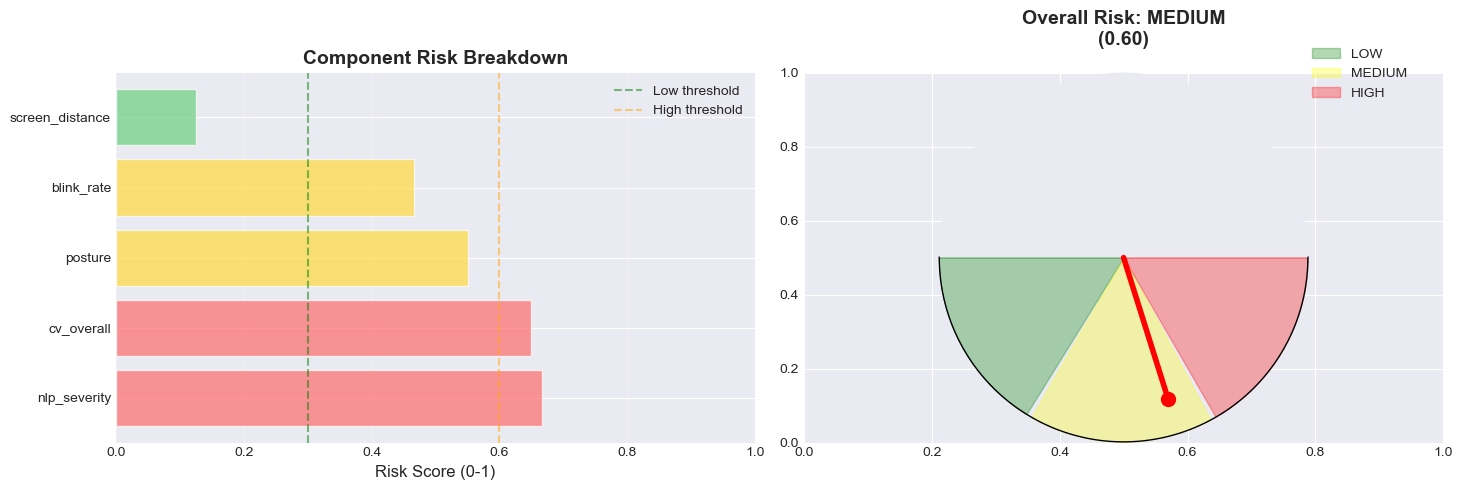

In [12]:
# Visualize high risk case
fig = visualize_risk_assessment(result_high)
plt.show()

### Case 2: Medium Risk User

In [13]:
# Medium risk case
nlp_features_medium = NLPFeatures(
    discomfort_level=2,
    severity_label="Nhẹ",
    confidence=0.88,
    extracted_symptoms=["khô mắt nhẹ"],
    original_text="Mắt hơi khô và ngứa"
)

cv_features_medium = CVFeatures(
    risk_level=0.45,
    posture_score=65,
    blink_rate=11,
    screen_distance=55,
    duration_minutes=60
)

# Process (KEEP pipeline unchanged)
result_medium = pipeline.process(nlp_features_medium, cv_features_medium)

# Pretty print (single-language display)
severity_display = (
    SEVERITY_MAP_EN.get(nlp_features_medium.severity_label, nlp_features_medium.severity_label)
    if LANG == "en"
    else nlp_features_medium.severity_label
)

print("CASE 2: MEDIUM RISK USER" if LANG == "en" else "TRƯỜNG HỢP 2: NGUY CƠ TRUNG BÌNH")

print("\nInput:" if LANG == "en" else "\nĐầu vào:")
print(
    f"  User says: '{nlp_features_medium.original_text}'"
    if LANG == "en"
    else f"  Người dùng nói: '{nlp_features_medium.original_text}'"
)
print(f"  Severity: {severity_display}" if LANG == "en" else f"  Mức độ: {severity_display}")
print(
    f"  Blink rate: {cv_features_medium.blink_rate}/min"
    if LANG == "en"
    else f"  Tần suất chớp mắt: {cv_features_medium.blink_rate}/phút"
)
print(
    f"  Screen distance: {cv_features_medium.screen_distance} cm"
    if LANG == "en"
    else f"  Khoảng cách màn hình: {cv_features_medium.screen_distance} cm"
)
print(
    f"  Posture score: {cv_features_medium.posture_score}/100"
    if LANG == "en"
    else f"  Điểm tư thế: {cv_features_medium.posture_score}/100"
)

risk_assessment = result_medium.get("risk_assessment", {})
print("\nRisk Assessment:" if LANG == "en" else "\nĐánh giá rủi ro:")
print(
    f"  Overall Risk: {risk_assessment.get('combined_risk_score', 0):.2f}"
    if LANG == "en"
    else f"  Rủi ro tổng hợp: {risk_assessment.get('combined_risk_score', 0):.2f}"
)
print(
    f"  Category: {risk_assessment.get('risk_category', 'N/A')}"
    if LANG == "en"
    else f"  Nhóm: {risk_assessment.get('risk_category', 'N/A')}"
)
print(
    f"  Urgency: {risk_assessment.get('urgency', 'N/A')}"
    if LANG == "en"
    else f"  Mức độ khẩn: {risk_assessment.get('urgency', 'N/A')}"
)

explanation = result_medium.get("explanation", {})
root_cause = pick_text(explanation, "root_cause", LANG)

print("\nRoot Cause Analysis:" if LANG == "en" else "\nPhân tích nguyên nhân:")
print(root_cause or (explanation.get("root_cause") or ""))

# Recommendations (KEEP existing helper)
print_recommendations(result_medium)

# Disclaimer (bilingual support with fallback)
disclaimer_text = result_medium.get(f"disclaimer_{LANG}") or result_medium.get("disclaimer", "")
print("\n" + disclaimer_text)


CASE 2: MEDIUM RISK USER

Input:
  User says: 'Mắt hơi khô và ngứa'
  Severity: Mild
  Blink rate: 11/min
  Screen distance: 55 cm
  Posture score: 65/100

Risk Assessment:
  Overall Risk: 0.35
  Category: MEDIUM
  Urgency: caution

Root Cause Analysis:
Your reported symptom severity 'Nhẹ' may be caused by:

• Low blink rate (11 blinks/min compared to the normal 15–20):
  When focusing on screens, the brain's high concentration reduces blinking,
  causing faster tear evaporation and resulting in dryness and irritation.


These causes can be improved through behavioral adjustments.

BEHAVIORAL RECOMMENDATIONS

1. 🟠 [HIGH] Increase blinking frequency
    Blink fully 10–15 times, then gently close your eyes for 2 seconds. Repeat every 20 minutes.
     Duration: 30 seconds
     Category: exercise

2. 🟡 [MEDIUM] Apply the 20-20-20 rule
    Every 20 minutes, look at an object 20 feet (6 meters) away for 20 seconds to relax the eye muscles.
     Duration: 20 seconds every 20 minutes
     Cate

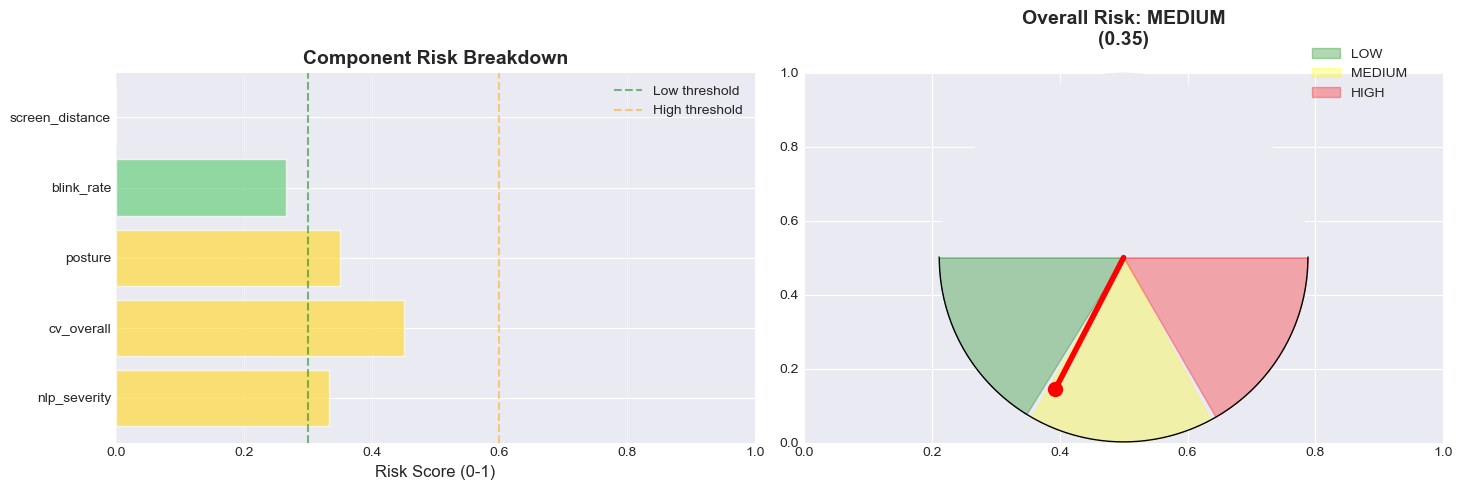

In [14]:
# Visualize medium risk case
fig = visualize_risk_assessment(result_medium)
plt.show()

### Case 3: Low Risk User

In [19]:
# Low risk case
nlp_features_low = NLPFeatures(
    discomfort_level=1,
    severity_label="None",
    confidence=0.92,
    extracted_symptoms=[],
    original_text="Mắt bình thường"
)

cv_features_low = CVFeatures(
    risk_level=0.2,
    posture_score=85,
    blink_rate=16,
    screen_distance=60,
    duration_minutes=30
)

# Process (KEEP pipeline unchanged)
result_low = pipeline.process(nlp_features_low, cv_features_low)

# Pretty print (single-language display)

severity_display = (
    SEVERITY_MAP_EN.get(nlp_features_low.severity_label, nlp_features_low.severity_label)
    if LANG == "en"
    else nlp_features_low.severity_label
)

print("\n" + "=" * 70)
print("CASE 3: LOW RISK USER" if LANG == "en" else "TRƯỜNG HỢP 3: NGUY CƠ THẤP")
print("=" * 70)

print("\nInput:" if LANG == "en" else "\nĐầu vào:")
print(
    f"  User says: '{nlp_features_low.original_text}'"
    if LANG == "en"
    else f"  Người dùng nói: '{nlp_features_low.original_text}'"
)
print(f"  Severity: {severity_display}" if LANG == "en" else f"  Mức độ: {severity_display}")
print(
    f"  Blink rate: {cv_features_low.blink_rate}/min"
    if LANG == "en"
    else f"  Tần suất chớp mắt: {cv_features_low.blink_rate}/phút"
)
print(
    f"  Screen distance: {cv_features_low.screen_distance} cm"
    if LANG == "en"
    else f"  Khoảng cách màn hình: {cv_features_low.screen_distance} cm"
)
print(
    f"  Posture score: {cv_features_low.posture_score}/100"
    if LANG == "en"
    else f"  Điểm tư thế: {cv_features_low.posture_score}/100"
)

risk_assessment = result_low.get("risk_assessment", {})
print("\nRisk Assessment:" if LANG == "en" else "\nĐánh giá rủi ro:")
print(
    f"  Overall Risk: {risk_assessment.get('combined_risk_score', 0):.2f}"
    if LANG == "en"
    else f"  Rủi ro tổng hợp: {risk_assessment.get('combined_risk_score', 0):.2f}"
)
print(
    f"  Category: {risk_assessment.get('risk_category', 'N/A')}"
    if LANG == "en"
    else f"  Nhóm: {risk_assessment.get('risk_category', 'N/A')}"
)
print(
    f"  Urgency: {risk_assessment.get('urgency', 'N/A')}"
    if LANG == "en"
    else f"  Mức độ khẩn: {risk_assessment.get('urgency', 'N/A')}"
)

explanation = result_low.get("explanation", {})
root_cause = pick_text(explanation, "root_cause", LANG)

print("\nRoot Cause Analysis:" if LANG == "en" else "\nPhân tích nguyên nhân:")
print(root_cause or (explanation.get("root_cause") or ""))

# Recommendations (KEEP existing helper)
print_recommendations(result_low)

# Disclaimer (bilingual support with fallback)
disclaimer_text = result_low.get(f"disclaimer_{LANG}") or result_low.get("disclaimer", "")
print("\n" + disclaimer_text)



CASE 3: LOW RISK USER

Input:
  User says: 'Mắt bình thường'
  Severity: None
  Blink rate: 16/min
  Screen distance: 60 cm
  Posture score: 85/100

Risk Assessment:
  Overall Risk: 0.08
  Category: LOW
  Urgency: normal

Root Cause Analysis:
Your reported symptom severity 'None' may be caused by:


These causes can be improved through behavioral adjustments.

BEHAVIORAL RECOMMENDATIONS

1. 🟡 [MEDIUM] Apply the 20-20-20 rule
    Every 20 minutes, look at an object 20 feet (6 meters) away for 20 seconds to relax the eye muscles.
     Duration: 20 seconds every 20 minutes
     Category: routine

DISCLAIMER: This is preventive guidance and does NOT replace medical consultation.
If symptoms persist for more than 3 days or become severe, please consult an ophthalmologist.



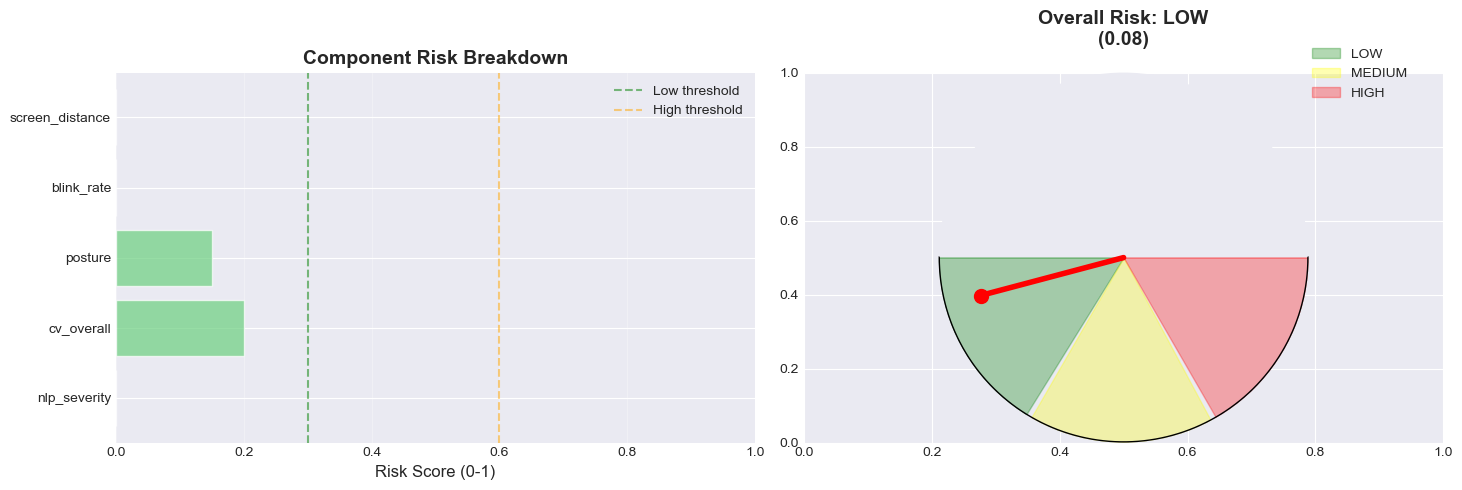

In [20]:
# Visualize low risk case
fig = visualize_risk_assessment(result_low)
plt.show()

## 11. Compare All Cases

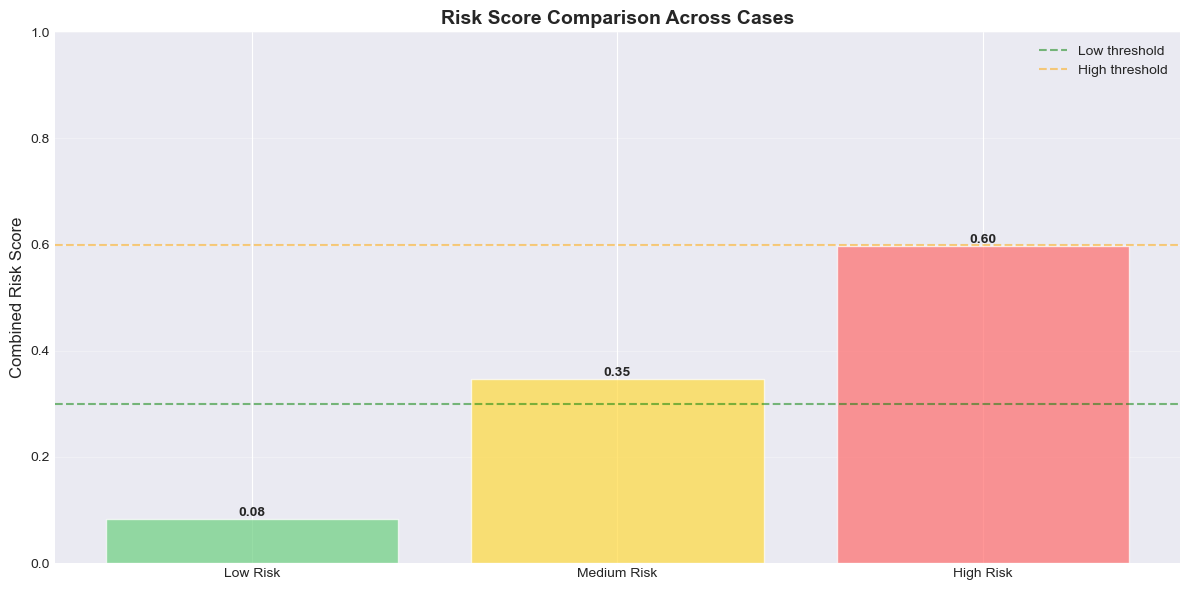

In [22]:
# Compare risk scores across cases
cases = ['Low Risk', 'Medium Risk', 'High Risk']
risk_scores = [
    result_low['risk_assessment']['combined_risk_score'],
    result_medium['risk_assessment']['combined_risk_score'],
    result_high['risk_assessment']['combined_risk_score']
]

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#6bcf7f', '#ffd93d', '#ff6b6b']
bars = ax.bar(cases, risk_scores, color=colors, alpha=0.7)

ax.axhline(y=0.3, color='green', linestyle='--', alpha=0.5, label='Low threshold')
ax.axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='High threshold')

ax.set_ylabel('Combined Risk Score', fontsize=12)
ax.set_title('Risk Score Comparison Across Cases', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, risk_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.2f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 12. Export Results

In [18]:
# Save results to JSON
output = {
    'high_risk_case': result_high,
    'medium_risk_case': result_medium,
    'low_risk_case': result_low
}

with open('module2_results.json', 'w', encoding='utf-8') as f:
    json.dump(output, f, indent=2, ensure_ascii=False)

print("Results saved to 'module2_results.json'")

✅ Results saved to 'module2_results.json'


## Summary

### Module 2 Features:

1. **Multimodal Fusion**
   - Combines NLP features (symptoms) with CV features (behavior)
   - Weighted risk scoring system
   - Normalized feature scaling

2. **RAG-based Retrieval**
   - AAO guideline database
   - Context-aware retrieval
   - Rule-based selection (can be upgraded to vector search)

3. **Intelligent Explanation**
   - Root cause analysis in Vietnamese
   - Behavior-consequence mapping
   - Evidence-based explanations

4. **Personalized Recommendations**
   - Priority-based action items
   - Category-organized (rest, exercise, ergonomics, routine)
   - Duration and urgency information

5. **Safety First**
   - Medical claim filtering
   - Mandatory disclaimers
   - No treatment advice

### Key Strengths:
- No training required - rule-based system
- Explainable AI - clear reasoning
- Multilingual support (English + Vietnamese)
- Scalable architecture
- Safety-focused design